# GEOG5995M Final Assignment 

Student ID number: 201786172

# How does the number of older people supported by the local authority for social care needs vary across England, and why might that be?

Adult social care in its simplest terms means help with day-to-day living. This could include support for those with a learning disability, assistance to help people struggling with mobility issues stay independent in their own home, or placements in care homes when they need round-the-clock support. In England this care is means-tested, unlike the NHS which is free at the point of contact, and where individuals are eligible for state support, this is arranged by local authorities. This means that the numbers supported per local authority can vary considerably across England.

I was keen to use open data to provide additional insight into the provision of long term adult social care in England for adults aged 65 and older. This would be achieved with visualisations that made it easy for the public to understand some factors which might influence how this varies across the country. My intended audience is the general public, or as described in the Office for National Statistics User Personas, Inquiring Citizens who "want simply worded, visually engaging summaries, charts and infographics" <a href="https://service-manual.ons.gov.uk/content/writing-for-users/user-personas#inquiring-citizens">[1]</a>.

Local authorities (unlike other geographical boundaries such as Lower Super Output Areas which have a relatively similar population) vary in size. As such, I chose to use adult social care data that had already been linked with population data, to provide a uniform metric for standardisation and comparison.

This notebook outlines the process I followed, linking additional datasets to try and account for the variation. I used the five stages of data science process, Collection, Cleaning, Exploratory Data Analysis, Model Building and Model Deployment, as per the course materials <a href="https://github.com/FrancescaPontin/GEOG5995">[2]</a>. I adopted an iterative process, with checks after each step, so that if any issues emerged, they could be quickly rectified. Choices made whilst preparing and visualising the data are noted throughout.





# Non-spatial visualisation

## Data Collection

In [1]:
# import required packages

# for visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# for data manipulation
import pandas as pd
import numpy as np

# for statistical insight
import scipy as sp

# for spatial visualisation
import geopandas as gpd

In [2]:
# minimise chance of warning messages carrying through which could disrupt the readability of the notebook and associated outputs
import warnings
warnings.filterwarnings('ignore')

Adult Social Care activity data for England was downloaded from NHS England <a href="https://digital.nhs.uk/data-and-information/publications/statistical/adult-social-care-activity-and-finance-report/2021-22">[3]</a>. 

In [3]:
# as there are a number of rows/columns that are not needed for this analysis, remove on import
activity_all = pd.read_excel('ASCFR and SALT Data Tables 2021-22.xlsx', sheet_name='T36', 
                   skiprows = range(1, 21),
                   usecols = "A:E,I")


In [4]:
# check the data has loaded as expected
activity_all.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 8
0,E06000057,104,Northumberland,E12000001,North East,6345
1,E08000037,106,Gateshead,E12000001,North East,6765
2,E08000021,107,Newcastle upon Tyne,E12000001,North East,7535
3,E08000022,108,North Tyneside,E12000001,North East,6420
4,E08000023,109,South Tyneside,E12000001,North East,8145


In [5]:
# we have reduced it down to just the fields we need however to avoid confusion, columns will need renaming

activity_all.rename(columns = {'Unnamed: 0':'Geography code', 'Unnamed: 1':'LA code',
                              'Unnamed: 2':'LA name',
                              'Unnamed: 3':'Region code',
                              'Unnamed: 4':'Region name',
                              'Unnamed: 8':'Older Clients per 100,000 population'}, inplace = True)

In [6]:
# check the renaming has worked as expected
activity_all.head()

,Geography code,LA code,LA name,Region code,Region name,"Older Clients per 100,000 population"
0,E06000057,104,Northumberland,E12000001,North East,6345
1,E08000037,106,Gateshead,E12000001,North East,6765
2,E08000021,107,Newcastle upon Tyne,E12000001,North East,7535
3,E08000022,108,North Tyneside,E12000001,North East,6420
4,E08000023,109,South Tyneside,E12000001,North East,8145


I am choosing to link this adult social care activity data with Index of Multiple Deprivation (IMD) data which may provide extra context: as Adult Social Care is means tested, support from the local authority could be more prevalent in more deprived areas.

This data was downloaded from the Department of Levelling Up, Housing and Communities (DLUHC) <a href="https://www.gov.uk/government/statistics/english-indices-of-deprivation-2019">[4]</a>. It is useful to note that unlike the adult social care data which covers the 2021/22 financial year, the most recent IMD data is from 2019 and as such, there may have been some geographical boundary changes in the interim.

In [7]:
# load in IMD data
deprivation_olderpeople = pd.read_excel('File_11_-_IoD2019_Local_Authority_District_Summaries__upper-tier__.xlsx', sheet_name='IDAOPI')


In [8]:
# explore this data and identify key for merging the two data sets on
deprivation_olderpeople.head()

,Upper Tier Local Authority District code (2019),Upper Tier Local Authority District name (2019),IDAOPI - Average rank,IDAOPI - Rank of average rank,IDAOPI - Average score,IDAOPI - Rank of average score,IDAOPI - Proportion of LSOAs in most deprived 10% nationally,IDAOPI - Rank of proportion of LSOAs in most deprived 10% nationally
0,E06000001,Hartlepool,21237.10,29,0.228,26,0.2931,15
1,E06000002,Middlesbrough,20061.41,37,0.233,22,0.3837,11
2,E06000003,Redcar and Cleveland,16716.82,71,0.168,64,0.1477,47
3,E06000004,Stockton-on-Tees,15589.56,85,0.160,74,0.1417,50
4,E06000005,Darlington,15702.96,84,0.152,80,0.0769,68


In [9]:
# join the two datasets together, by the ONS geography code they both have in common
activity_deprivation  = pd.merge(activity_all, deprivation_olderpeople,  left_on='Geography code', right_on='Upper Tier Local Authority District code (2019)', how='left')

In [10]:
# check the join has worked as expected
activity_deprivation

,Geography code,LA code,LA name,Region code,Region name,"Older Clients per 100,000 population",Upper Tier Local Authority District code (2019),Upper Tier Local Authority District name (2019),IDAOPI - Average rank,IDAOPI - Rank of average rank,IDAOPI - Average score,IDAOPI - Rank of average score,IDAOPI - Proportion of LSOAs in most deprived 10% nationally,IDAOPI - Rank of proportion of LSOAs in most deprived 10% nationally
0,E06000057,104,Northumberland,E12000001,North East,6345,E06000057,Northumberland,12768.39,106.0,0.115,105.0,0.0102,126.0
1,E08000037,106,Gateshead,E12000001,North East,6765,E08000037,Gateshead,19741.06,39.0,0.194,44.0,0.1270,54.0
2,E08000021,107,Newcastle upon Tyne,E12000001,North East,7535,E08000021,Newcastle upon Tyne,19812.19,38.0,0.218,31.0,0.2857,17.0
3,E08000022,108,North Tyneside,E12000001,North East,6420,E08000022,North Tyneside,16728.50,70.0,0.160,72.0,0.0763,69.0
4,E08000023,109,South Tyneside,E12000001,North East,8145,E08000023,South Tyneside,21479.71,28.0,0.214,33.0,0.1176,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,[x] indicates data not submitted.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159,[c] indicates data less than 5.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
160,Some data may not sum due to rounding.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleaning

In [11]:
# having identified that the data is also showing footnotes etc from the activity source file, cleanse to just show data
activity_deprivation_data_only = activity_deprivation.iloc[0:152]

In [12]:
# check this has worked as expected
activity_deprivation_data_only

,Geography code,LA code,LA name,Region code,Region name,"Older Clients per 100,000 population",Upper Tier Local Authority District code (2019),Upper Tier Local Authority District name (2019),IDAOPI - Average rank,IDAOPI - Rank of average rank,IDAOPI - Average score,IDAOPI - Rank of average score,IDAOPI - Proportion of LSOAs in most deprived 10% nationally,IDAOPI - Rank of proportion of LSOAs in most deprived 10% nationally
0,E06000057,104,Northumberland,E12000001,North East,6345,E06000057,Northumberland,12768.39,106.0,0.115,105.0,0.0102,126.0
1,E08000037,106,Gateshead,E12000001,North East,6765,E08000037,Gateshead,19741.06,39.0,0.194,44.0,0.1270,54.0
2,E08000021,107,Newcastle upon Tyne,E12000001,North East,7535,E08000021,Newcastle upon Tyne,19812.19,38.0,0.218,31.0,0.2857,17.0
3,E08000022,108,North Tyneside,E12000001,North East,6420,E08000022,North Tyneside,16728.50,70.0,0.160,72.0,0.0763,69.0
4,E08000023,109,South Tyneside,E12000001,North East,8145,E08000023,South Tyneside,21479.71,28.0,0.214,33.0,0.1176,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,E06000024,910,North Somerset,E12000009,South West,3825,E06000024,North Somerset,11067.19,126.0,0.104,124.0,0.0370,93.0
148,E06000025,911,South Gloucestershire,E12000009,South West,4490,E06000025,South Gloucestershire,9522.40,138.0,0.087,137.0,0.0000,139.0
149,E10000008,912,Devon,E12000009,South West,4120,E10000008,Devon,12069.15,115.0,0.106,120.0,0.0044,134.0
150,E06000026,913,Plymouth,E12000009,South West,5670,E06000026,Plymouth,16163.19,78.0,0.153,78.0,0.0497,85.0


National Statistics publications typically have set annotations for suppressed or missing data, such as [x] or [c] so data pre-processing will require more than a regular df.isna() check.

In [13]:
# ensure all missing data is consistent, so check for annotated data and replace with NaN
activity_deprivation_data_only.replace('[x]',np.nan,inplace=True)
activity_deprivation_data_only.replace('[c]',np.nan,inplace=True)

In [14]:
# convert this column to numeric for analytical purposes
activity_deprivation_data_only["Older Clients per 100,000 population"] = pd.to_numeric(activity_deprivation_data_only["Older Clients per 100,000 population"])

In [15]:
# check summary statistics for any anomalies
activity_deprivation_data_only.describe()

,"Older Clients per 100,000 population",IDAOPI - Average rank,IDAOPI - Rank of average rank,IDAOPI - Average score,IDAOPI - Rank of average score,IDAOPI - Proportion of LSOAs in most deprived 10% nationally,IDAOPI - Rank of proportion of LSOAs in most deprived 10% nationally
count,151.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000
mean,5702.947020,16450.254698,75.281879,0.166034,75.308725,0.122526,75.040268
std,1667.631281,5399.823004,43.533628,0.070478,43.561063,0.146398,43.056512
min,2890.000000,3656.000000,1.000000,0.050000,1.000000,0.000000,1.000000
25%,4407.500000,12113.230000,38.000000,0.113000,38.000000,0.016800,38.000000
50%,5490.000000,16285.460000,75.000000,0.159000,75.000000,0.066400,75.000000
75%,6645.000000,19812.190000,113.000000,0.208000,113.000000,0.174900,113.000000
max,10555.000000,30443.390000,151.000000,0.439000,151.000000,0.770800,139.000000


Some of the counts differ by variable so a full check for missing data will be undertaken. As it's a large dataframe (152 rows by 14 columns) a true/false isna() view is not easy to scan for missing values so I will just check the rows with missing data.

In [16]:
# check for missing data by row as with a dataframe 152 rows by 14 columns, 
# a true/false isna() view is not easy to scan for missing values
check = activity_deprivation_data_only[activity_deprivation_data_only.isna().any(axis=1)]
print(check)

    Geography code LA code                 LA name Region code    Region name  \
58       E06000062   U6Q5Z   West Northamptonshire   E12000004  East Midlands   
59       E06000061   Z9D4Z  North Northamptonshire   E12000004  East Midlands   
87       E09000012     704                 Hackney   E12000007         London   
136      E06000060     916         Buckinghamshire   E12000008     South East   

     Older Clients per 100,000 population  \
58                                 3420.0   
59                                 4025.0   
87                                    NaN   
136                                3475.0   

    Upper Tier Local Authority District code (2019)  \
58                                              NaN   
59                                              NaN   
87                                        E09000012   
136                                             NaN   

    Upper Tier Local Authority District name (2019)  IDAOPI - Average rank   \
58           

All four rows will be removed, as it is not possible to impute the missing values; Hackney were unable to submit adult social care data due to a cyber attack, whilst Buckinghamshire, West Northamptonshire and North Northamptonshire have changed their boundaries/are new authorities since the IMD data was published in 2019, meaning there is no deprivation data associated with their current area.

In [17]:
# remove rows where data is missing
activity_deprivation_data_clean = activity_deprivation_data_only.dropna()

In [18]:
# check this has worked as expected
activity_deprivation_data_clean

,Geography code,LA code,LA name,Region code,Region name,"Older Clients per 100,000 population",Upper Tier Local Authority District code (2019),Upper Tier Local Authority District name (2019),IDAOPI - Average rank,IDAOPI - Rank of average rank,IDAOPI - Average score,IDAOPI - Rank of average score,IDAOPI - Proportion of LSOAs in most deprived 10% nationally,IDAOPI - Rank of proportion of LSOAs in most deprived 10% nationally
0,E06000057,104,Northumberland,E12000001,North East,6345.0,E06000057,Northumberland,12768.39,106.0,0.115,105.0,0.0102,126.0
1,E08000037,106,Gateshead,E12000001,North East,6765.0,E08000037,Gateshead,19741.06,39.0,0.194,44.0,0.1270,54.0
2,E08000021,107,Newcastle upon Tyne,E12000001,North East,7535.0,E08000021,Newcastle upon Tyne,19812.19,38.0,0.218,31.0,0.2857,17.0
3,E08000022,108,North Tyneside,E12000001,North East,6420.0,E08000022,North Tyneside,16728.50,70.0,0.160,72.0,0.0763,69.0
4,E08000023,109,South Tyneside,E12000001,North East,8145.0,E08000023,South Tyneside,21479.71,28.0,0.214,33.0,0.1176,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,E06000024,910,North Somerset,E12000009,South West,3825.0,E06000024,North Somerset,11067.19,126.0,0.104,124.0,0.0370,93.0
148,E06000025,911,South Gloucestershire,E12000009,South West,4490.0,E06000025,South Gloucestershire,9522.40,138.0,0.087,137.0,0.0000,139.0
149,E10000008,912,Devon,E12000009,South West,4120.0,E10000008,Devon,12069.15,115.0,0.106,120.0,0.0044,134.0
150,E06000026,913,Plymouth,E12000009,South West,5670.0,E06000026,Plymouth,16163.19,78.0,0.153,78.0,0.0497,85.0


In [19]:
# check datatypes to ensure the data we want to analyse is in numerical format
activity_deprivation_data_clean.dtypes

Geography code                                                            object
LA code                                                                   object
LA name                                                                   object
Region code                                                               object
Region name                                                               object
Older Clients per 100,000 population                                     float64
Upper Tier Local Authority District code (2019)                           object
Upper Tier Local Authority District name (2019)                           object
IDAOPI - Average rank                                                    float64
IDAOPI - Rank of average rank                                            float64
IDAOPI - Average score                                                   float64
IDAOPI - Rank of average score                                           float64
IDAOPI - Proportion  of LSOA

In [20]:
# check names to ensure that any changes to format can be correctly applied
activity_deprivation_data_clean.columns.tolist()

['Geography code',
 'LA code',
 'LA name',
 'Region code',
 'Region name',
 'Older Clients per 100,000 population',
 'Upper Tier Local Authority District code (2019)',
 'Upper Tier Local Authority District name (2019)',
 'IDAOPI - Average rank ',
 'IDAOPI - Rank of average rank ',
 'IDAOPI - Average score ',
 'IDAOPI - Rank of average score ',
 'IDAOPI - Proportion  of LSOAs in most deprived 10% nationally ',
 'IDAOPI - Rank of proportion of LSOAs in most deprived 10% nationally ']

In [21]:
# note the trailing space in this variable was not immediately apparent until columns.tolist above was actioned
activity_deprivation_data_clean["IDAOPI - Average score "] = pd.to_numeric(activity_deprivation_data_clean["IDAOPI - Average score "])

In [22]:
# ensure this format is updated in case the merge affected this
activity_deprivation_data_clean["Older Clients per 100,000 population"] = pd.to_numeric(activity_deprivation_data_clean["Older Clients per 100,000 population"])

## Exploratory Data Analysis

Univariate analysis, considering just the social care activity variable in isolation, is useful before analysing its relationship with deprivation data.

<Axes: xlabel='Older Clients per 100,000 population', ylabel='Count'>

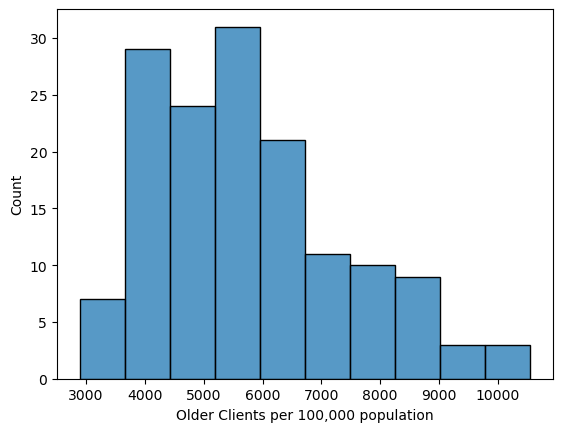

In [23]:
# visualise numerical variable of interest - histogram
sns.histplot(data=activity_deprivation_data_clean, x="Older Clients per 100,000 population")

<Axes: xlabel='Older Clients per 100,000 population'>

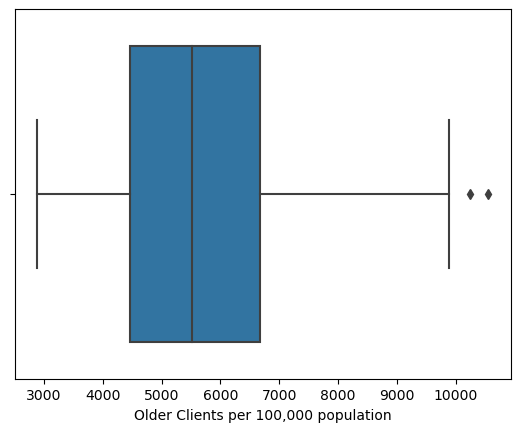

In [24]:
# visualise numerical variable of interest - boxplot 
sns.boxplot(data=activity_deprivation_data_clean, x="Older Clients per 100,000 population")

These two visualisations reveal data is not distributed normally, and highlight a couple of outliers, so a better understanding of the relationship between this variable and deprivation data may help account for this. 

In [25]:
# now missing data has been removed, check summary statistics of clean data set for any anomalies
activity_deprivation_data_clean.describe()

,"Older Clients per 100,000 population",IDAOPI - Average rank,IDAOPI - Rank of average rank,IDAOPI - Average score,IDAOPI - Rank of average score,IDAOPI - Proportion of LSOAs in most deprived 10% nationally,IDAOPI - Rank of proportion of LSOAs in most deprived 10% nationally
count,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000
mean,5744.763514,16355.706486,75.783784,0.164405,75.804054,0.118146,75.540541
std,1657.592748,5292.959148,43.246728,0.067848,43.285896,0.136748,42.765995
min,2890.000000,3656.000000,2.000000,0.050000,1.000000,0.000000,2.000000
25%,4471.250000,12110.512500,38.750000,0.112500,38.750000,0.016775,38.750000
50%,5512.500000,16257.030000,75.500000,0.157500,75.500000,0.066150,75.500000
75%,6673.750000,19758.842500,113.250000,0.204250,113.250000,0.174825,113.250000
max,10555.000000,30099.770000,151.000000,0.439000,151.000000,0.694400,139.000000


The summary statistics suggest that there are also some outliers in the IDAOPI - Average score variable which is the measure of Index of Multiple Deprivation we will be using.

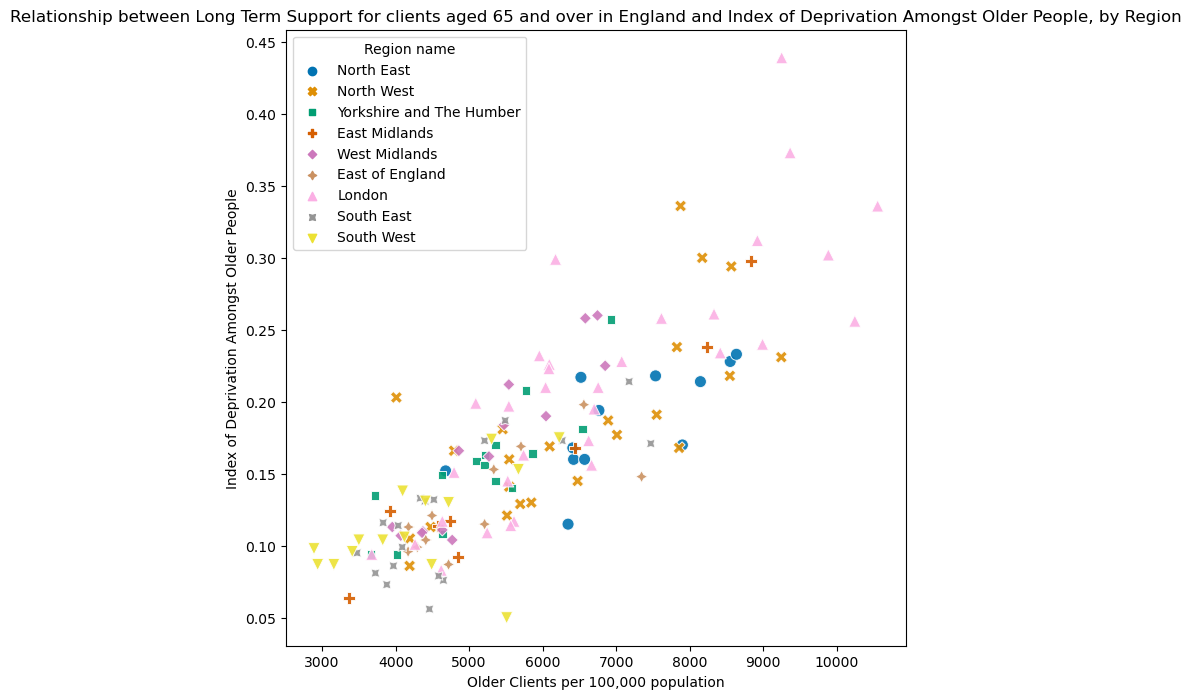

In [26]:
# initial visualisation incorporating accessible markers and colourscheme
fig, ax = plt.subplots(figsize=(8,8))

sns.scatterplot( x='Older Clients per 100,000 population',y='IDAOPI - Average score ', s=75, hue = 'Region name', style = 'Region name', palette = 'colorblind', alpha=0.9, marker = "p", data = activity_deprivation_data_clean);

# title and axis labels added to be more intuitive than variable names
ax.set_title('Relationship between Long Term Support for clients aged 65 and over in England and Index of Deprivation Amongst Older People, by Region')
ax.set_xlabel('Older Clients per 100,000 population')
ax.set_ylabel('Index of Deprivation Amongst Older People');

As a preliminary visualisation, whilst the marker differentiation is useful, I felt it detracted from the ease of initial interpretation as the different shapes made some regions seem more prominent.

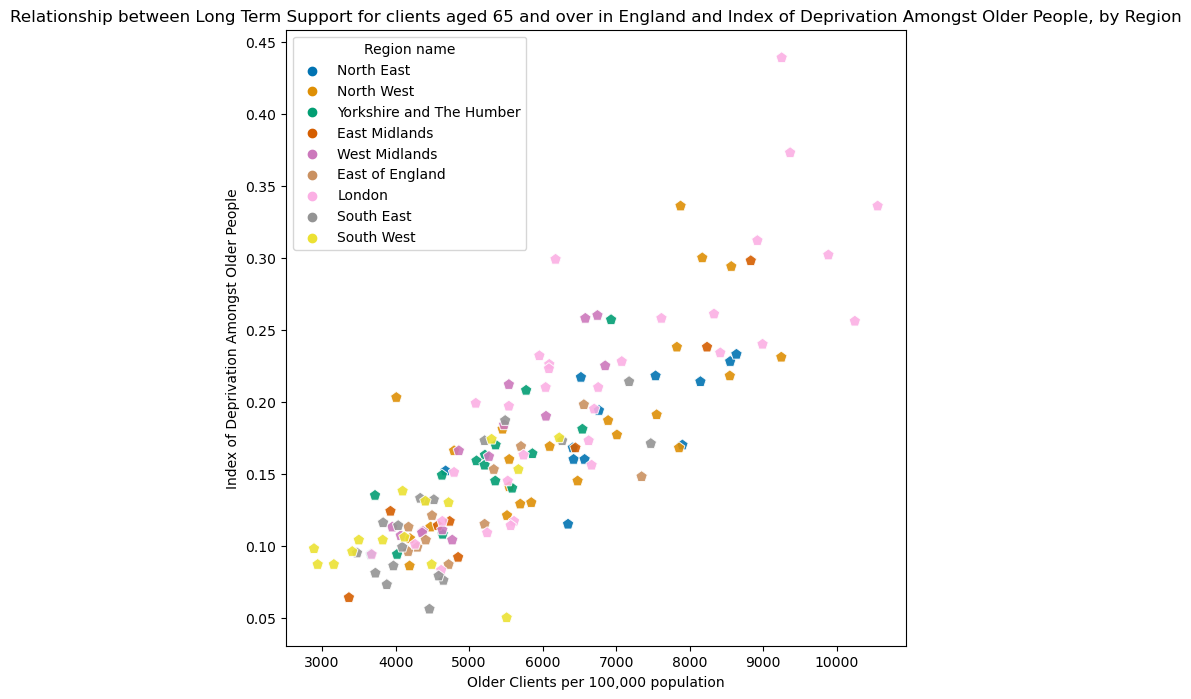

In [27]:
# although marker differentiation is useful, felt in example above it detracted from initial interpretation 
# as shape made some regions seem more prominent
fig, ax = plt.subplots(figsize=(8,8))

sns.scatterplot( x='Older Clients per 100,000 population',y='IDAOPI - Average score ', s=75, hue = 'Region name',  palette = 'colorblind', alpha=0.9, marker = "p", data = activity_deprivation_data_clean);

# title and axis labels added to be more intuitive than variable names
ax.set_title('Relationship between Long Term Support for clients aged 65 and over in England and Index of Deprivation Amongst Older People, by Region')
ax.set_xlabel('Older Clients per 100,000 population')
ax.set_ylabel('Index of Deprivation Amongst Older People');

## Model Building

In line with the Inquiring Citizen persona, a simple model was chosen, calculating the correlation co-efficient between the two variables, with support from Stack Overflow <a href="https://stackoverflow.com/questions/70759369/adding-correlation-coefficient-to-a-seaborn-scatter-plot">[5]</a> to ultimately reflect this in the non-spatial visualisation.

In [28]:
# determine correlation co-efficient and save for future deployment in visualisations
r, p = sp.stats.pearsonr(x=activity_deprivation_data_clean['Older Clients per 100,000 population'], y=activity_deprivation_data_clean['IDAOPI - Average score '])
r

0.8336488302894993

To provide an alternative option, the regression between the two variables was plotted.

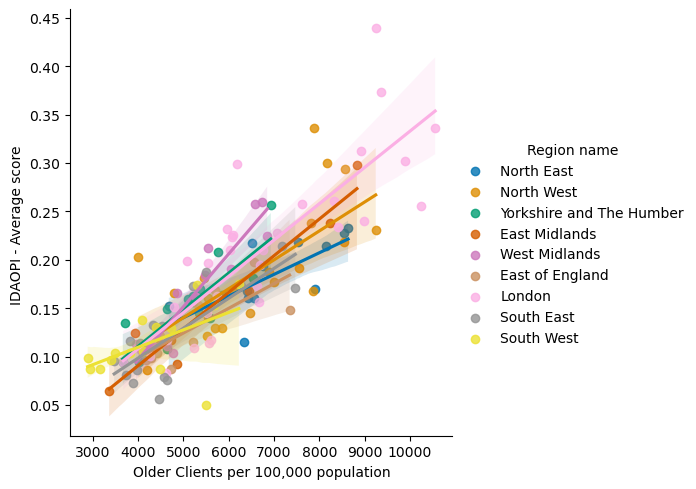

In [29]:
# consider regression between the two variables
sns.lmplot(x='Older Clients per 100,000 population', y='IDAOPI - Average score ',data = activity_deprivation_data_clean, hue = 'Region name', palette = 'colorblind')

Although this provides additional detail, modelling the regression line for each Local Authority, it does mean the visualisation is quite busy and could detract from the simpler messaging this project is aiming for, so I decided to stick with the correlation co-efficient.

## Model Deployment

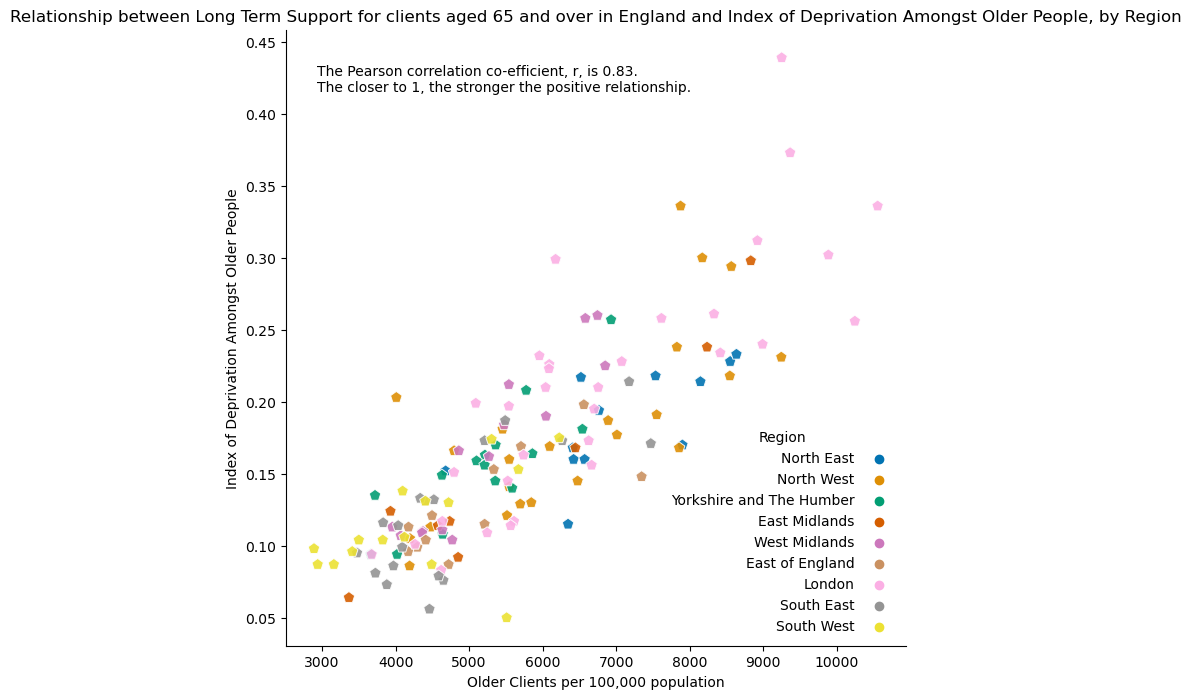

In [30]:
fig, ax = plt.subplots(figsize=(8,8))

sns.scatterplot( x='Older Clients per 100,000 population',y='IDAOPI - Average score ', s=75, hue = 'Region name',  palette = 'colorblind', alpha=0.9, marker = "p", data = activity_deprivation_data_clean);
#reposition legend and give it a title
sns.move_legend( ax, "lower right", bbox_to_anchor=(1, 0), title = 'Region', markerfirst=False, frameon=False)
sns.despine()
# title and axis labels added to be more intuitive than variable names
ax.set_title('Relationship between Long Term Support for clients aged 65 and over in England and Index of Deprivation Amongst Older People, by Region')
ax.set_xlabel('Older Clients per 100,000 population')
ax.set_ylabel('Index of Deprivation Amongst Older People')
# add some extra text underneath r = 0.83 to explain what this means.
plt.text(.05, .9, 'The Pearson correlation co-efficient, r, is {:.2f}.\nThe closer to 1, the stronger the positive relationship.'.format(r), transform=ax.transAxes);




## Summary on non-spatial visualisation

The use of a scatter plot here makes it immediately apparent that as deprivation increases, so does the number of older clients per 100,000 population supported. Selecting a different colour for each region in England adds an extra layer of insight, and highlights that the highest values, for both deprivation and population supported (depicted top right) are in London. The legend was moved to bottom right, with the marker to the right of the Region name so as not to get confused with actual data points.

The intended audience is the general public, our Inquiring Citizens, therefore an intuitive visualisation (identifying patterns as we look from left to right on the plot) not dependant on specialist knowledge was chosen. The inclusion of the correlation co-efficient however is useful to confirm the strength of the relationship between the two variables without requiring a high level statistical background.

I wanted to incorporate the NHS England colour palette <a href="https://www.england.nhs.uk/nhsidentity/identity-guidelines/colours/">[6]</a> into my final non-spatial visualisation but this range contained just 5 blues - as there are 9 regions in England, I felt this would be better for my spatial visualisation and so in this instance, my main colour focus was to ensure the palette was colourblind safe. 



# Spatial visualisation

## Data collection

An extra file was required to support the spatial visualisation, downloaded from the UKDataService's Boundary Data Selector <a href="https://borders.ukdataservice.ac.uk/bds.html">[7]</a>

In [31]:
# for mapping, load shape file at local authority level in England as social care is devolved across the nations and delivered by local authorities
# to note, files needed to be moved out of folder for this section of code to run
LA_shape =gpd.read_file('england_utla_2022_bgc.shp')

In [32]:
# check this is as expected
LA_shape.head()

,label,name,utla22cd,utla22nm,utla22nmw,geometry
0,E92000001E12000009E06000027,Torbay,E06000027,Torbay,None,"POLYGON ((287648.062 57900.835, 287450.406 579..."
1,E92000001E12000005E10000034,Worcestershire,E10000034,Worcestershire,None,"POLYGON ((376225.687 237546.797, 376093.406 23..."
2,E92000001E12000008E10000016,Kent,E10000016,Kent,None,"MULTIPOLYGON (((551208.125 140136.391, 551190...."
3,E92000001E12000002E10000006,Cumbria,E10000006,Cumbria,None,"MULTIPOLYGON (((298509.610 507908.720, 298458...."
4,E92000001E12000004E10000018,Leicestershire,E10000018,Leicestershire,None,"POLYGON ((439618.837 293111.987, 439615.312 29..."


In [33]:
# just retain variables required - geography code for linkage and geometry
shape_reduced = LA_shape[['utla22cd','geometry']]

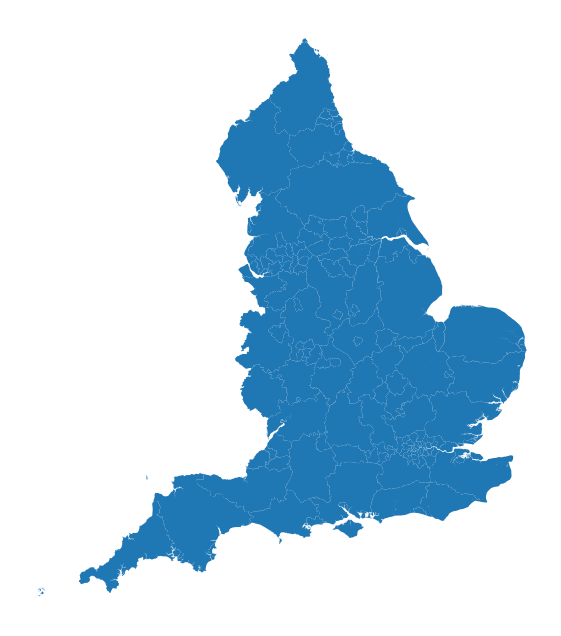

In [34]:
# plot the shape data to check it's plotting local authorities in England as expected
f,ax = plt.subplots(1, figsize=(16, 8))
shape_reduced.plot(ax=ax)
# make axis invisible 
ax.set_axis_off()
plt.show()

In [35]:
# merge this spatial data file with the combined activity/deprivation file from part one. 
# crucial to list shape file first otherwise mapping won't work later on
spatial_test = pd.merge(shape_reduced, activity_deprivation_data_clean, left_on='utla22cd', right_on='Geography code', how='left')

In [36]:
# check it's worked as expected. 
spatial_test

,utla22cd,geometry,Geography code,LA code,LA name,Region code,Region name,"Older Clients per 100,000 population",Upper Tier Local Authority District code (2019),Upper Tier Local Authority District name (2019),IDAOPI - Average rank,IDAOPI - Rank of average rank,IDAOPI - Average score,IDAOPI - Rank of average score,IDAOPI - Proportion of LSOAs in most deprived 10% nationally,IDAOPI - Rank of proportion of LSOAs in most deprived 10% nationally
0,E06000027,"POLYGON ((287648.062 57900.835, 287450.406 579...",E06000027,914,Torbay,E12000009,South West,5305.0,E06000027,Torbay,19176.51,42.0,0.174,54.0,0.0562,82.0
1,E10000034,"POLYGON ((376225.687 237546.797, 376093.406 23...",E10000034,416,Worcestershire,E12000005,West Midlands,4070.0,E10000034,Worcestershire,11605.84,122.0,0.107,119.0,0.0220,105.0
2,E10000016,"MULTIPOLYGON (((551208.125 140136.391, 551190....",E10000016,820,Kent,E12000008,South East,3830.0,E10000016,Kent,12888.75,104.0,0.116,104.0,0.0166,115.0
3,E10000006,"MULTIPOLYGON (((298509.610 507908.720, 298458....",E10000006,102,Cumbria,E12000002,North West,4195.0,E10000006,Cumbria,11383.27,124.0,0.105,121.0,0.0187,112.0
4,E10000018,"POLYGON ((439618.837 293111.987, 439615.312 29...",E10000018,508,Leicestershire,E12000004,East Midlands,4850.0,E10000018,Leicestershire,10194.55,134.0,0.092,136.0,0.0051,132.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,E06000033,"MULTIPOLYGON (((582953.400 184841.400, 582981....",E06000033,621,Southend-on-Sea,E12000006,East of England,5335.0,E06000033,Southend-on-Sea,16225.31,77.0,0.153,79.0,0.0561,83.0
148,E09000022,"POLYGON ((529095.425 169804.235, 529043.425 16...",E09000022,708,Lambeth,E12000007,London,9885.0,E09000022,Lambeth,26567.05,6.0,0.302,7.0,0.3876,10.0
149,E08000008,"POLYGON ((390188.544 394649.453, 390101.228 39...",E08000008,311,Tameside,E12000002,North West,7010.0,E08000008,Tameside,18775.42,46.0,0.177,52.0,0.0638,79.0
150,E09000020,"POLYGON ((523824.000 180096.346, 523914.759 18...",E09000020,707,Kensington and Chelsea,E12000007,London,5090.0,E09000020,Kensington and Chelsea,18273.49,51.0,0.199,40.0,0.2330,25.0


## Exploratory data analysis

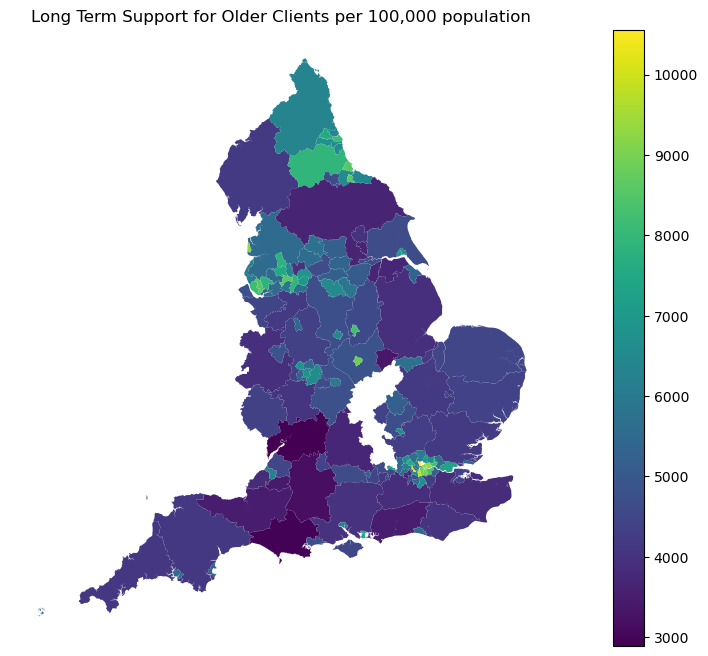

In [37]:
# first attempt depict basic variation by council, default colour scheme 
# Define plot size
f,ax = plt.subplots(1, figsize=(16,8))
# Plot the older clients per 100,000 variable
# Add legend (legend =True)

spatial_test.plot(ax=ax, column ='Older Clients per 100,000 population', legend=True)
ax.set_title('Long Term Support for Older Clients per 100,000 population')
# make axis invisible 
ax.set_axis_off()
# show the map
plt.show()

The above visualisation highlights that the data cleansing necessary for the non-spatial visualisation (removing all missing data across the two variables of interest) removes data that could otherwise be depicted in the map above (e.g. the two Northamptonshire codes and Buckinghamshire that had boundary changes after the IMD data was released). As such, it is sensible to create a second clean dataset to maximise data coverage for mapping purposes.

In [38]:
# merge this spatial data file with the combined activity/deprivation file from part one. 
# crucial to name shape file first otherwise mapping won't work later on
spatial_test2 = pd.merge(shape_reduced, activity_deprivation_data_only, left_on='utla22cd', right_on='Geography code', how='left')

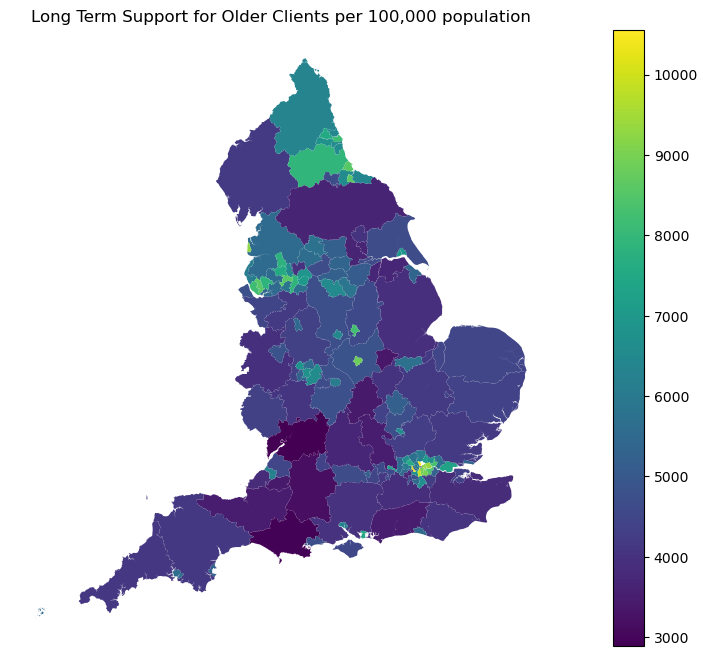

In [39]:
# rerun previous visualisation to see if initial missing data issues resolved, default colour scheme
# Define plot size
f,ax = plt.subplots(1, figsize=(16,8))
# Plot the older clients per 100,000 variable
# Add legend (legend =True)

spatial_test2.plot(ax=ax, column ='Older Clients per 100,000 population', legend=True)
ax.set_title('Long Term Support for Older Clients per 100,000 population')
# make axis invisible 
ax.set_axis_off()
# show the map
plt.show()

This step improved coverage however there are still some issues, as whilst the current legend format shows the range in values, it doesn't clearly highlight that white space equates with missing data. Equally, this allocation of colours to values happens automatically which is appropriate when we just have one visualisation to depict, but could cause confusion if we want to add an additional plot alongside, as colours could end up being associated with different values. It is possible to use a 'user defined' scheme <a href="https://stackoverflow.com/questions/41783090/plotting-a-choropleth-map-with-geopandas-using-a-user-defined-classification-s">[8]</a> to define bins, however I kept getting errors when trying to run this on my system. Although this was explored at length to try and resolve the issue, the point arose where it was better to find a workaround rather than continue to invest time in working out why 'user defined' wasn't working, so as not to jeopardise the assignment.  

In [40]:
# new code to try and label bins and mitigate against 'user defined' not working as expected
def new_bin (series):
    if  2800<= series < 4360 :
        return "2800-4360"
    elif 4360<= series <5920:
        return "4360-5920"
    elif 5920<= series <7480:
        return "5920-7480"
    elif 7480<= series <9040:
        return "7480-9040"
    elif 9040<= series <10600:
        return "9040-10600"
    
spatial_test2['Older Clients'] = spatial_test2['Older Clients per 100,000 population'].apply(new_bin)

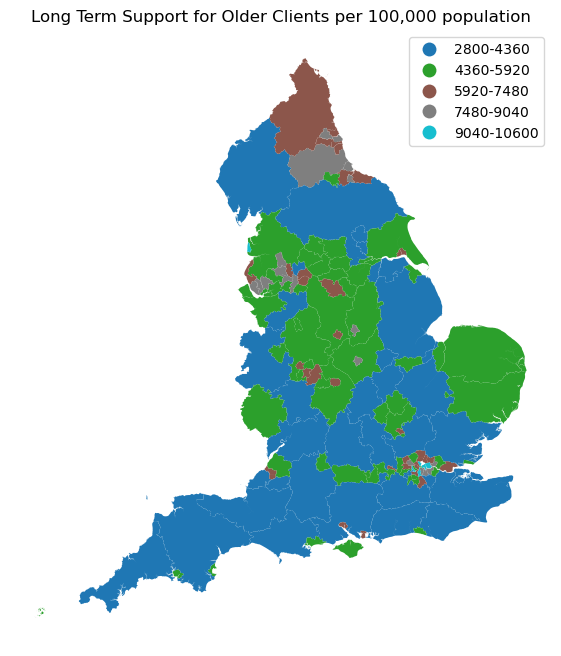

In [41]:
# visualisation testing with categorical new labels, default colour scheme
# Define plot size
f,ax = plt.subplots(1, figsize=(16,8))
# Plot the older clients per 100,000 variable
# Add legend (legend =True)

spatial_test2.plot(ax=ax, column ='Older Clients', legend=True)
ax.set_title('Long Term Support for Older Clients per 100,000 population')
# make axis invisible 
ax.set_axis_off()
# show the map
plt.show()

In [42]:
# now the bins are working as expected, introduce preferred colourscheme
# create a new colour map using NHS England corporate colours
# note the order so that when this is used for mapping, the lighter colours are used for lower numbers 
from matplotlib.colors import ListedColormap

newcmap = ListedColormap(["#00A9CE", "#41B6E6", "#0072CE", "#005EB8","#003087"])

An extra feature was added to better support the depiction of missing data in the legend <a href="https://geopandas.org/en/stable/docs/user_guide/mapping.html">[9]</a> including a black border to make this more prominent.

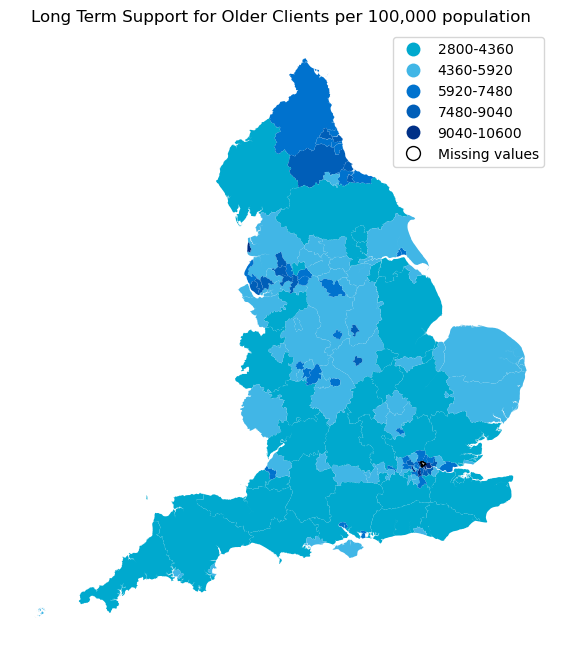

In [43]:
# Define plot size
f,ax = plt.subplots(1, figsize=(16,8))

# Add legend (legend =True)

spatial_test2.plot(ax=ax, column ='Older Clients', legend=True, cmap = newcmap, missing_kwds={
        "color": "white",
        "edgecolor": "black",
        
        "label": "Missing values",
    },)
ax.set_title('Long Term Support for Older Clients per 100,000 population')
# make axis invisible 
ax.set_axis_off()
# show the map
plt.show()

I then created a sub-plot of London as there is much variation within this area which can get lost in the full England map.

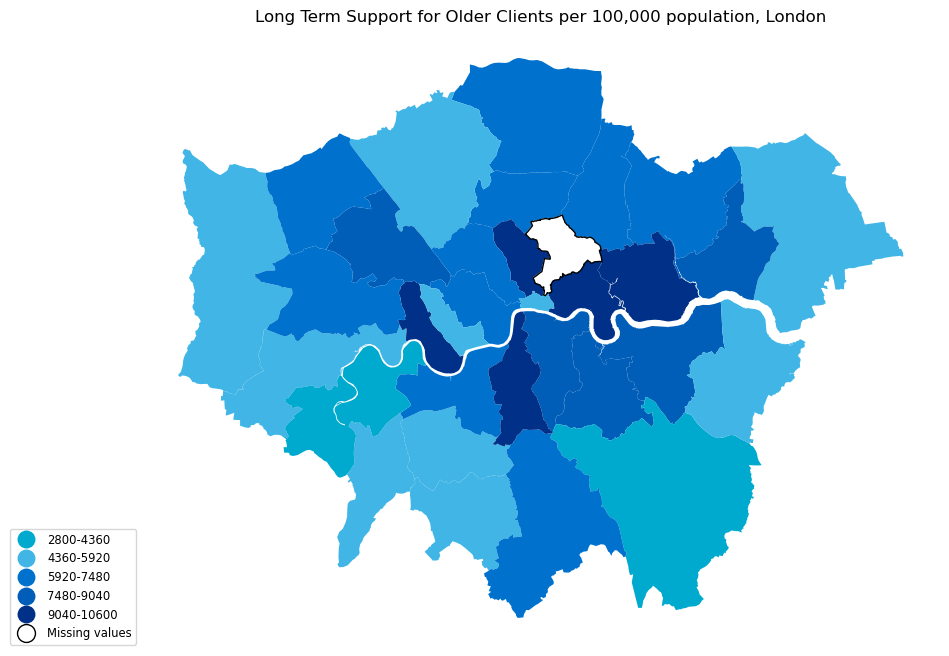

In [44]:
# Note, by manualling setting the bins, we can now be consistent across both plots
# subset London 
spatial_London2 = spatial_test2.loc[spatial_test2['Region name']=='London']
# Define plot size
f,ax = plt.subplots(1, figsize=(16,8))

# Add legend (legend =True)

spatial_London2.plot(ax=ax, column ='Older Clients', legend=True, cmap = newcmap, legend_kwds={
                        'bbox_to_anchor':(0, .2), 
                        'markerscale':1.29, 
                        'title_fontsize':'medium', 
                        'fontsize':'small'}, missing_kwds={
        "color": "white",
        "edgecolor": "black",
        
        "label": "Missing values",
    },)
ax.set_title('Long Term Support for Older Clients per 100,000 population, London')


# make axis invisible 
ax.set_axis_off()
# show the map
plt.show()

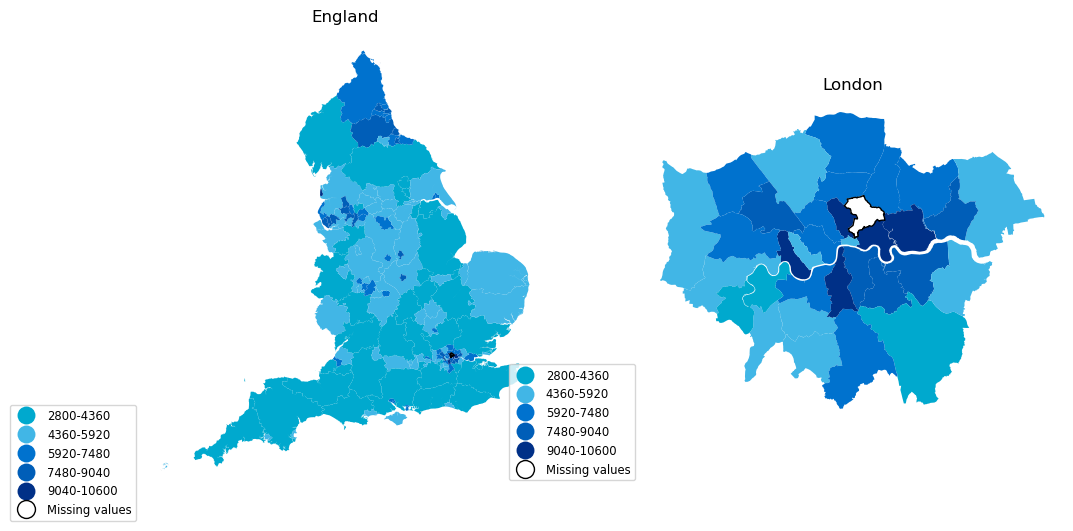

In [45]:
# create a figure with two subplots to better illustrate the variation in London, alongside the overall view
f,ax = plt.subplots(1,2, figsize=(12,6))

# plot England in subplot 1

spatial_test2.plot(ax=ax [0], column ='Older Clients', legend=True, cmap = newcmap, legend_kwds={
                        'bbox_to_anchor':(0, .2), 
                        'markerscale':1.29, 
                        'title_fontsize':'medium', 
                        'fontsize':'small'}, missing_kwds={
        "color": "white",
        "edgecolor": "black",
        
        "label": "Missing values",
    }, )

# plot London in subplot 2

spatial_London2.plot(ax=ax [1], column ='Older Clients', legend=True, cmap = newcmap, legend_kwds={
                        'bbox_to_anchor':(0, .2), 
                        'markerscale':1.29, 
                        'title_fontsize':'medium', 
                        'fontsize':'small'}, missing_kwds={
        "color": "white",
        "edgecolor": "black",
        
        "label": "Missing values",
    }, )

# give subplot 1 an informative title
ax[0].set_title('England')

# give subplot 2 an informative title
ax[1].set_title('London')

# make axis invisible for subplot 1
ax[0].set_axis_off()

# make axis invisible for subplot 2
ax[1].set_axis_off()

# show figure
plt.show()

This is getting closer to the final visualisation however it would look be better to adjust the placement of the legend and only show it once, as I have already ensured the labelling is consistent. Furthermore, I want to adjust the proportions between England and London and add a master title.

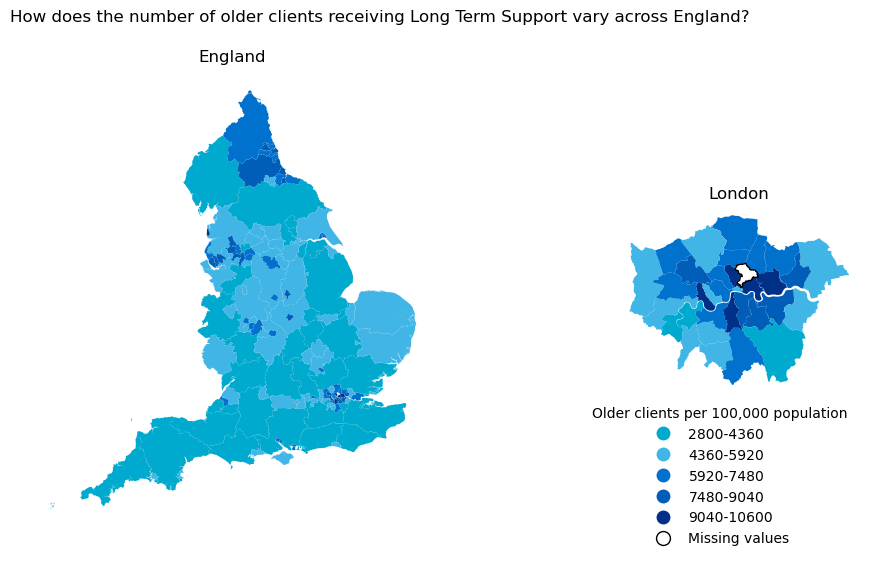

In [46]:
# This will be my final spatial visualisation
# create a figure with two subplots
f,ax = plt.subplots(1,2, figsize=(12,6), gridspec_kw={'width_ratios': [5, 2]})


# plot England in subplot 1

spatial_test2.plot(ax=ax [0], column ='Older Clients',  cmap = newcmap)

# plot London in subplot 2

spatial_London2.plot(ax=ax [1], column ='Older Clients', cmap = newcmap, legend = True, legend_kwds={'title':'Older clients per 100,000 population',
                        'bbox_to_anchor':(1, 0), 'frameon' : False }, missing_kwds={
        "color": "white",
        "edgecolor": "black",
        
        "label": "Missing values",
    },)


# give subplot 1 an informative title
ax[0].set_title('England')

# give subplot 2 an informative title
ax[1].set_title('London')

# make axis invisible for subplot 1
ax[0].set_axis_off()

# make axis invisible for subplot 2
ax[1].set_axis_off()

# overall title
plt.suptitle('How does the number of older clients receiving Long Term Support vary across England?')

# show figure
plt.show()

## Summary on spatial visualisation
I used an iterative process, starting with a basic plot, with a default colour palette, to check the functionality worked in the first instance, then introducing design choices to maximise the ease of interpretation. 
I chose to display two plots, England and then a call-out plot to highlight the variation within London that could have been lost otherwise. In a way that is accessible to all, and does not rely on specialist knowledge, the England spatial visualisation draws our attention to the fact that the number of clients supported increases in more urban areas, whilst the London sub-plot highlights not only the areas where most people are supported most in the country, but also the extent to which provision can differ in just one region. Both visualisations have provided insight for a general public audience into the original question posed: How does the number of older people supported by the local authority for social care needs vary across England, and why might that be?

## References
<p><a href="https://service-manual.ons.gov.uk/content/writing-for-users/user-personas#inquiring-citizens">[1]</a> Office for National Statistics User Personas</p>
<p><a href="https://github.com/FrancescaPontin/GEOG5995">[2]</a> GEOG5995M course materials</p>
<p><a href="https://digital.nhs.uk/data-and-information/publications/statistical/adult-social-care-activity-and-finance-report/2021-22">[3]</a> Adult Social Care National Activity Data</p>
<p><a href="https://www.gov.uk/government/statistics/english-indices-of-deprivation-2019">[4]</a> Index of Multiple Deprivation Data</p>
<p><a href="https://stackoverflow.com/questions/70759369/adding-correlation-coefficient-to-a-seaborn-scatter-plot">[5]</a> Adding correlation co-efficient information to a plot</p>
<p><a href="https://www.england.nhs.uk/nhsidentity/identity-guidelines/colours/">[6]</a> NHS England colour scheme</p>
<p><a href="https://borders.ukdataservice.ac.uk/bds.html">[7]</a> UTLA Boundary Data Selector</p>
<p><a href="https://stackoverflow.com/questions/41783090/plotting-a-choropleth-map-with-geopandas-using-a-user-defined-classification-s">[8]</a> User defined classification in geopandas chloropleth maps</p>
<p><a href="https://geopandas.org/en/stable/docs/user_guide/mapping.html">[9]</a> Adding missing values to a legend</p>